# Connect Colab to Drive

--> Click on install Drive on the left side in Files

# Imports

In [ ]:
!pip install transformers
!pip install wandb -qqq
!pip install sentencepiece
import wandb
wandb.login()

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import argparse
import torchvision.transforms as transforms
import sentencepiece
import glob
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Data

In [ ]:
path_to_data = 'drive/MyDrive/BazarAfrique/data/Rakuten_Challenge'

In [ ]:
# # Copy the zip image folder to the local machine and unzip it

# %%time
# zip_path = path_to_data + '/images.zip'
# !cp "{zip_path}" .
# !unzip -q images.zip
# !rm images.zip

In [ ]:
# Training data
df_features = pd.read_csv(path_to_data + '/X_train_update.csv', sep=',')
df_labels = pd.read_csv(path_to_data + '/Y_train_CVw08PX.csv', sep=',')
# Test data
df_challenge = pd.read_csv(path_to_data + '/X_test_update.csv', sep=',')

In [ ]:
# Training data
data = pd.concat([df_features, df_labels['prdtypecode']], axis=1)  # add the class label to the dataframe containing the features
data.drop(columns=['Unnamed: 0'], inplace=True)
data.columns = ['title', 'description', 'productid', 'imageid', 'label']  # new column names

In [ ]:
# %%time
# train_img_data_path = 'images/image_train'
# data['imagepath'] = [glob.glob(os.path.join(train_img_data_path, f'image_{img_id}*.jpg'))[0] for img_id in data['imageid']]
# data['imagepath'].to_csv('image_paths.csv', index=False)

data['imagepath'] = pd.read_csv(path_to_data + '/image_paths.csv')

In [ ]:
data

,title,description,productid,imageid,label,imagepath
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,images/image_train/image_1263597046_product_38...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,images/image_train/image_1008141237_product_43...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,images/image_train/image_938777978_product_201...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,images/image_train/image_457047496_product_504...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,images/image_train/image_1077757786_product_27...
...,...,...,...,...,...,...
84911,The Sims [ Import Anglais ],NaN,206719094,941495734,40,images/image_train/image_941495734_product_206...
84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,2583,images/image_train/image_1188462883_product_30...
84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617,2280,images/image_train/image_1009325617_product_44...
84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,1560,images/image_train/image_1267353403_product_39...


In [ ]:
# To run only one time then you can just load this image paths with the last line in this cell
# %%time
# challenge_img_data_path = 'images/image_test'
# df_challenge['imagepath'] = [glob.glob(os.path.join(challenge_img_data_path, f'image_{img_id}*.jpg'))[0] for img_id in df_challenge['imageid']]
# df_challenge['imagepath'].to_csv(path_to_data + '/challenge_image_paths.csv', index=False)  # saving image paths

df_challenge['imagepath'] = pd.read_csv(path_to_data + '/challenge_image_paths.csv')

# Pre-processing

In [ ]:
def clean_text(text: str) -> str:
    """Clean a text by applying various pre-processing steps

    Parameters
    ----------
    text
        The text to process

    Returns
    -------
    str
        The cleaned text

    """
    text = text.replace("¿¿", "é")
    text = text.replace("+¿", "ë")
    text = text.replace("¿", "œ")
    text = text.replace("ã¢", "â")
    text = text.replace("+¿", "'")
    text = text.replace("<p align=&quot;justify&quot;>", "")
    text = text.replace("&quot;", '"')
    text = text.replace("&#34;", '"')
    text = text.replace("&#43;", "")
    text = text.replace("¿Uf,", "")
    text = text.replace("<br>", "")
    text = text.replace("<br />", "")
    text = text.replace('<span class="vga_style2">', "")
    text = text.replace("<b>", "")
    text = text.replace("</b>", "")
    text = text.replace("</strong>", "")
    text = text.replace("<strong>", "")
    text = text.replace("</li>", "")
    text = text.replace("<li>", "")
    text = text.replace("</LI>", "")
    text = text.replace("<LI>", "")
    text = text.replace("<ul>", "")
    text = text.replace("</ul>", "")
    text = text.replace("<u>", "")
    text = text.replace("</u>", "")
    text = text.replace("&amp;", "")
    text = text.replace("nbsp;", "")
    text = text.replace("<div> ", "")
    text = text.replace("</div>", "")
    text = text.replace("<em>", "")
    text = text.replace("</p>", "")
    text = text.replace("<p>", "")
    text = text.lower()  
    text = text.strip()  # remove the whitespaces from the left and the right
    return text

In [ ]:
# Clean the titles 
data['title'] = data['title'].apply(lambda title: clean_text(title))  # Training and validation data
df_challenge['designation'] = df_challenge['designation'].apply(lambda title: clean_text(title))  # Challenge data

# Clean the descriptions
data['description'].fillna('', inplace=True)  # Replace NaN with empty string
data['description'] = data['description'].apply(lambda description: clean_text(description))

# Save data
!mkdir data
data.to_csv('data/full_data.csv', sep=',', index=False)

# Exploratory data analysis


## Label distribution

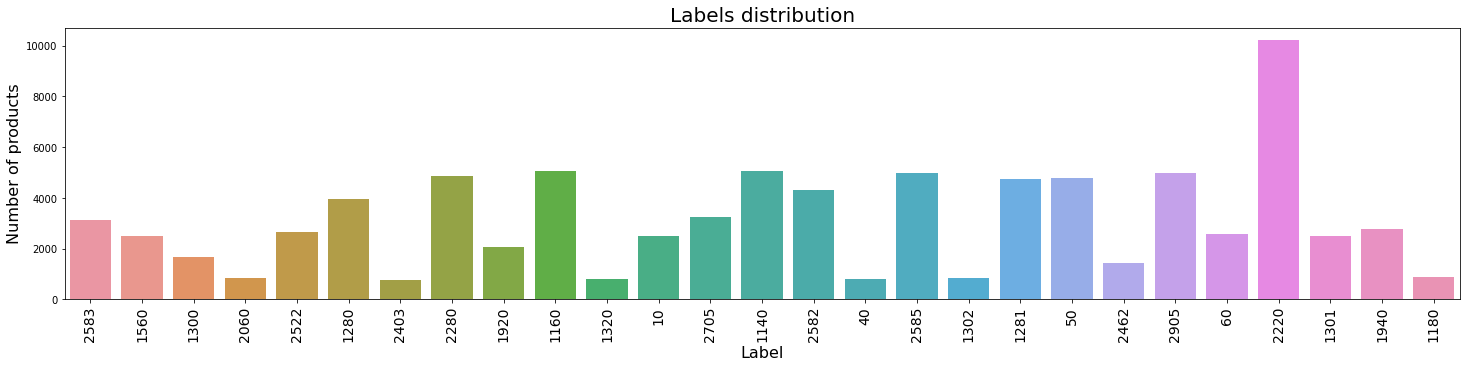

In [ ]:
# Distribution of labels 
all_labels = list(data.label.values)
labels, labels_counts = zip(*Counter(all_labels).most_common())
plt.figure(figsize=(25,5))
ax = sns.barplot(list(labels), list(labels_counts))
plt.title("Labels distribution", fontsize=20)
plt.xlabel("Label", fontsize=16)
ax.set_xticklabels(labels, rotation=90, fontsize=14)
plt.ylabel("Number of products", fontsize=16)
plt.show()

In [ ]:
nb_labels = len(np.unique(data.label.values))
print(f'Nb of unique labels: {nb_labels}')

Nb of unique labels: 27


## Missing values

In [ ]:
# print(f'Nb of examples: {len(data)}')
# print()
# print('Nb of missing values in each column:')
# print()
# print(data.isnull().sum()) 

## Length statistics

Title statistics:
min length: 11
mean length: 70.10663479202977
max length: 250


<Figure size 1800x360 with 0 Axes>

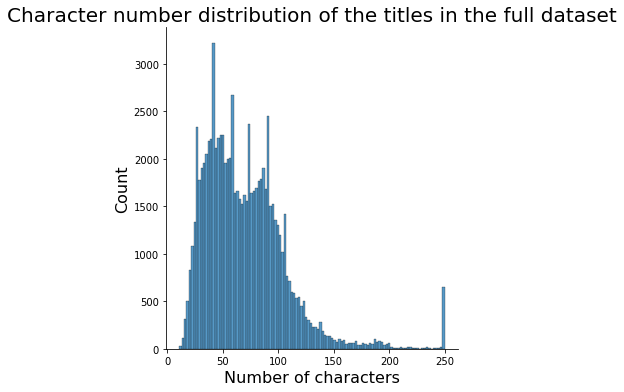

percentage of exples with less than 110 characters in the title: 89.83 %
percentage of exples with less than 115 characters in the title: 91.66 %
percentage of exples with less than 130 characters in the title: 95.12 %
percentage of exples with less than 150 characters in the title: 97.12 %
percentage of exples with less than 200 characters in the title: 98.93 %
Description statistics:
min length: 0
mean length: 499.32784163173017
max length: 12441


<Figure size 1800x360 with 0 Axes>

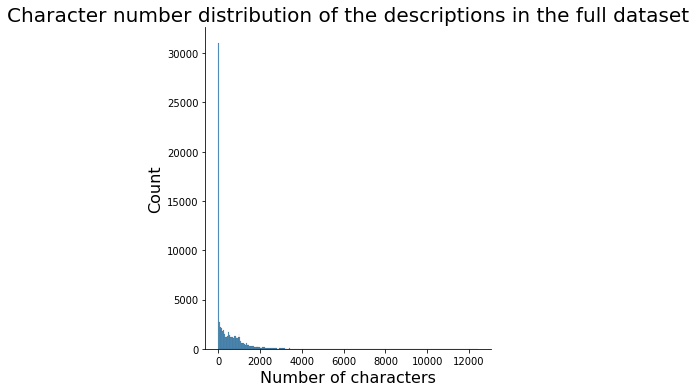

percentage of exples with less than 110 characters in the description: 42.62 %
percentage of exples with less than 115 characters in the description: 42.93 %
percentage of exples with less than 130 characters in the description: 43.92 %
percentage of exples with less than 150 characters in the description: 45.34 %
percentage of exples with less than 200 characters in the description: 48.42 %


In [ ]:
# Titles
titles = data.title.values
lengths = np.array([len(title) for title in titles])
print('Title statistics:')
print(f'min length: {lengths.min()}')
print(f'mean length: {lengths.mean()}')
print(f'max length: {lengths.max()}')
# Visualisation of the histogram
plt.figure(figsize=(25,5))
ax = sns.displot(lengths)
plt.title(f"Character number distribution of the titles in the full dataset", fontsize=20)
plt.xlabel("Number of characters", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.show()
max = [110, 115, 130, 150, 200]
for m in max:
    percentage = sum(lengths <= m) / len(lengths) * 100
    print(f"percentage of exples with less than {m} characters in the title: {round(percentage,2)} %")

# Descriptions
descriptions = data.description.values
lengths = np.array([len(desc) for desc in descriptions])
print('Description statistics:')
print(f'min length: {lengths.min()}')
print(f'mean length: {lengths.mean()}')
print(f'max length: {lengths.max()}')
# Visualisation of the histogram
plt.figure(figsize=(25,5))
ax = sns.displot(lengths)
plt.title(f"Character number distribution of the descriptions in the full dataset", fontsize=20)
plt.xlabel("Number of characters", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.show()
max = [110, 115, 130, 150, 200]
for m in max:
    percentage = sum(lengths <= m) / len(lengths) * 100
    print(f"percentage of exples with less than {m} characters in the description: {round(percentage,2)} %")

Description statistics:
min length: 0
mean length: 499.32784163173017
max length: 12441


<Figure size 1800x360 with 0 Axes>

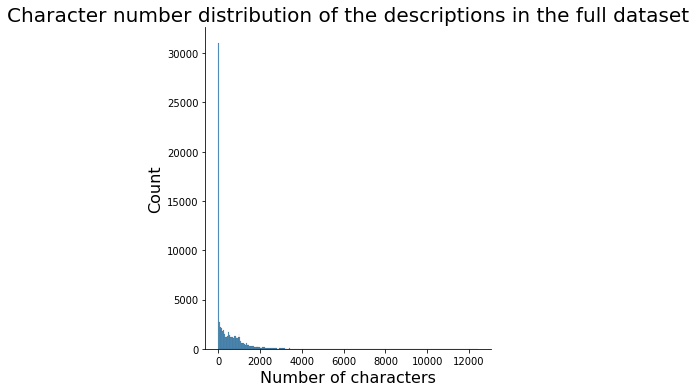

In [ ]:
# Descriptions
descriptions = data.description.values
lengths = np.array([len(desc) for desc in descriptions])
print('Description statistics:')
print(f'min length: {lengths.min()}')
print(f'mean length: {lengths.mean()}')
print(f'max length: {lengths.max()}')
# Visualisation of the histogram
plt.figure(figsize=(25,5))
ax = sns.displot(lengths)
plt.title(f"Character number distribution of the descriptions in the full dataset", fontsize=20)
plt.xlabel("Number of characters", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.show()

In [ ]:
max = [2, 230, 600]
for m in max:
    percentage = sum(lengths <= m) / len(lengths) * 100
    print(f"percentage of exples with less than {m} characters in the description: {round(percentage,2)} %")

percentage of exples with less than 2 characters in the description: 35.23 %
percentage of exples with less than 230 characters in the description: 50.71 %
percentage of exples with less than 600 characters in the description: 67.52 %


# Data Split

In [ ]:
def set_seed(seed):
    """ Set all seeds to make results reproducible """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 123
set_seed(seed)

In [ ]:
# Split train/validation: 90%/10% with the same distribution of labels in each split
test_size = 0.1
X_train, X_val, y_train, y_val = train_test_split(data, data.label, test_size=test_size, random_state=seed, stratify=data.label)
print(f'length of X_train: {len(X_train)}')
print(f'length of X_val: {len(X_val)}')

# !mkdir data
X_train.to_csv('data/train.csv', sep=',', index=False)
X_val.to_csv('data/val.csv', sep=',', index=False)
df_challenge.to_csv('data/challenge.csv', sep=',', index=False)

length of X_train: 76424
length of X_val: 8492


# Metrics

In [ ]:
def compute_score(y_true, y_pred, print_score=False):
    """Print and compute the weighted-F1 score

    Parameters
    ----------
    y_true : 1d array-like
        Ground truth (correct) target values.
    y_pred : 1d array-like
        Estimated targets as returned by a classifier.
        
    Returns
    -------
    score : float
        The weighted-F1 score
    """
    score = f1_score(y_true, y_pred, average="weighted")
    if print_score:
        print(f'weighted-F1 score: {score}')
    return score

# Models

## Simple models with tf-idf features

In [ ]:
# Features
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

print(f'Shape of X_train_tfidf: {X_train_tfidf.shape}')
print(f'Shape of X_val_tfidf: {X_val_tfidf.shape}')

### Linear SVC

In [ ]:
# best_score = 0.0
# param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# clf_svc = LinearSVC(multi_class='ovr', random_state=seed, max_iter=1000, class_weight=None) 
# for param in ParameterGrid(param_grid):
#     clf_svc.set_params(**param)
#     clf_svc.fit(X_train_tfidf, y_train)  # Training
#     y_pred_on_val = clf_svc.predict(X_val_tfidf) # Prediction on the validation set
#     print(f"C: {param['C']}")
#     val_score = compute_score(y_true=y_val, y_pred=y_pred_on_val)
#     if val_score > best_score:
#         best_score = val_scorea
#         best_grid = param

# print(f'Best score: {best_score}')
# print(f'Best parameters: {best_grid}')

### Logistic regression

In [ ]:
# best_score = 0.0
# # param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver':['newton-cg', 'sag', 'saga', 'lbfgs']}
# param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver':['lbfgs']}
# clf_lr = LogisticRegression(multi_class='multinomial', random_state=seed, max_iter=1000, class_weight=None)
# for param in ParameterGrid(param_grid):
#     clf_lr.set_params(**param)
#     clf_lr.fit(X_train_tfidf, y_train)  # Training
#     y_pred_on_val = clf_lr.predict(X_val_tfidf) # Prediction on the validation set
#     print(f"param: {param}")
#     val_score = compute_score(y_true=y_val, y_pred=y_pred_on_val)
#     if val_score > best_score:
#         best_score = val_score
#         best_grid = param

# print(f'Best score: {best_score}')
# print(f'Best parameters: {best_grid}')

## Transformers

### Classes and functions

In [ ]:
# img_dataset = datasets.ImageFolder(root='images/', 
#                                          transform=transforms.Compose(
#                                         [   transforms.Resize(256),
#                                             transforms.CenterCrop(224),
#                                             transforms.ToTensor(),
#                                         ]))
# img_loader = DataLoader(dataset=img_dataset, batch_size=64)

# def get_mean_std(loader):
# # credits: https://github.com/aladdinpersson/Machine-Learning-Collection
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in tqdm(loader):
#         channels_sum += torch.mean(data, dim=[0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#         num_batches += 1
#     mean = channels_sum/num_batches
#     std = (channels_squared_sum/num_batches - mean**2)**0.5

#     return mean, std

# mean, std = get_mean_std(img_loader)
# print(mean)  # tensor([0.7475, 0.7273, 0.7112])
# print(std)  # tensor([0.3100, 0.3154, 0.3299])

In [ ]:
# Dataset

true_to_fake_labels = {10: 0, 40: 1, 50: 2, 60: 3, 1140: 4, 1160: 5, 1180:6, 1280: 7, 1281: 8,
                       1300: 9, 1301: 10, 1302: 11, 1320: 12, 1560: 13, 1920: 14, 1940: 15 , 2060: 16, 2220: 17, 2280: 18, 
                       2403: 19, 2462: 20, 2522: 21, 2582: 22, 2583: 23, 2585: 24, 2705: 25, 2905: 26}
fake_to_true_labels = {v: k for k, v in true_to_fake_labels.items()}

class TextDataset(Dataset):

    def __init__(self, filename, maxlen, with_labels=True, delimiter=',', transformer_model='camembert-base',
                 feature_col_name='title', label_col_name='label'):

        #Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter=delimiter, keep_default_na=False)

        #Initialize the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(transformer_model, use_fast=False)
        # Maximum length of the input tokenized sequence pair : if larger than "maxlen", the input is truncated
        # and else if smaller, the input is padded
        self.maxlen = maxlen
        self.with_labels = with_labels
        self.feature_col_name = feature_col_name
        self.label_col_name = label_col_name

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Selecting the sequence at the specified index in the data frame
        seq = str(self.df.loc[index, self.feature_col_name])

        # Tokenize the sequence-pair to get token ids
        encoded_pair = self.tokenizer(seq,
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=self.maxlen,
                                      return_tensors='pt')  # Return torch.Tensor objects
        # tensor of token ids
        token_ids = encoded_pair['input_ids'].squeeze(0)

        if self.with_labels:  # True if the dataset has labels
            label = self.df.loc[index, self.label_col_name]
            label = true_to_fake_labels[label]
            return token_ids, label
        else:
            return token_ids



class VisionDataset(Dataset):
    def __init__(self, filename, delimiter=',', img_id_col_name='imageid', img_path_col_name='imagepath',
                 with_labels=True, label_col_name='label'):
        #Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter=delimiter, keep_default_na=False)
        self.img_path_col_name = img_path_col_name
        self.img_id_col_name = img_id_col_name
        self.with_labels = with_labels
        self.label_col_name = label_col_name
        self.transforms = transforms.Compose(
        [   transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.7475, 0.7273, 0.7112],
                std=[0.3100, 0.3154, 0.3299],
            ),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_id = self.df.loc[index, self.img_id_col_name]
        image = None
        image = Image.open(
            self.df.loc[index, self.img_path_col_name]
        ).convert("RGB")
        image = self.transforms(image)

        if self.with_labels:  # True if the dataset has labels
            label = self.df.loc[index, self.label_col_name]
            label = true_to_fake_labels[label]
            return image, label
        else:
            return image



class MultimodalDataset(Dataset):
    def __init__(self, filename, maxlen, delimiter=',', transformer_model='camembert-base', 
                 feature_col_name='title', img_id_col_name='imageid', img_path_col_name='imagepath',
                 with_labels=True, label_col_name='label'):
        #Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter=delimiter, keep_default_na=False)
        self.img_path_col_name = img_path_col_name
        self.img_id_col_name = img_id_col_name
        self.with_labels = with_labels
        self.label_col_name = label_col_name
        self.transforms = transforms.Compose(
        [   transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.7475, 0.7273, 0.7112],
                std=[0.3100, 0.3154, 0.3299],
            ),
        ])
        #Initialize the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(transformer_model, use_fast=False)
        # Maximum length of the input tokenized sequence pair : if larger than "maxlen", the input is truncated
        # and else if smaller, the input is padded
        self.maxlen = maxlen
        self.feature_col_name = feature_col_name


    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_id = self.df.loc[index, self.img_id_col_name]
        image = None
        image = Image.open(
            self.df.loc[index, self.img_path_col_name]
        ).convert("RGB")
        image = self.transforms(image)
        # Selecting the sequence at the specified index in the data frame
        seq = str(self.df.loc[index, self.feature_col_name])
        # Tokenize the sequence-pair to get token ids
        encoded_pair = self.tokenizer(seq,
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=self.maxlen,
                                      return_tensors='pt')  # Return torch.Tensor objects
        # tensor of token ids
        token_ids = encoded_pair['input_ids'].squeeze(0)

        if self.with_labels:  # True if the dataset has labels
            label = self.df.loc[index, self.label_col_name]
            label = true_to_fake_labels[label]
            return token_ids, image, label
        else:
            return token_ids, image

In [ ]:
# Models

# Text model
class SequenceClassifier(nn.Module):
    def __init__(self, args):
        super(SequenceClassifier, self).__init__()
        self.args = args
        # Instantiating transformer model object
        self.model = AutoModelForSequenceClassification.from_pretrained(args.transformer_model, num_labels=args.n_classes)
        
    @autocast()  # run in mixed precision
    def forward(self, input_ids):
        outputs = self.model(input_ids, return_dict=True)
        logits = outputs.logits
        return logits


class TransformerEncoder(nn.Module):
    def __init__(self, args):
        super(TransformerEncoder, self).__init__()
        self.args = args
        self.model = AutoModel.from_pretrained(args.transformer_model)

    @autocast() # run in mixed precision
    def forward(self, input_ids):
        # Last layer hidden-state of the first token of the sequence (classification token) 
        # further processed by a Linear layer and a Tanh activation function
        outputs = self.model(input_ids, return_dict=True)  
        return outputs.pooler_output



# Vision model

# Adapted from https://github.com/facebookresearch/mmbt/blob/04a2edb9f85802cd5442acc6702829b0a20e7748/mmbt/models/image.py#L15
class ImageEncoder(nn.Module):
    def __init__(self, args):
        super(ImageEncoder, self).__init__()
        self.args = args
        if self.args.resnet == '152':
            model = torchvision.models.resnet152(pretrained=True)
        elif self.args.resnet == '50':
            model = torchvision.models.resnet50(pretrained=True)
        modules = list(model.children())[:-2]
        self.model = nn.Sequential(*modules)

        pool_func = (
            nn.AdaptiveAvgPool2d
            if args.img_embed_pool_type == "avg"
            else nn.AdaptiveMaxPool2d
        )

        if args.num_image_embeds in [1, 2, 3, 5, 7]:
            self.pool = pool_func((args.num_image_embeds, 1))
        elif args.num_image_embeds == 4:
            self.pool = pool_func((2, 2))
        elif args.num_image_embeds == 6:
            self.pool = pool_func((3, 2))
        elif args.num_image_embeds == 8:
            self.pool = pool_func((4, 2))
        elif args.num_image_embeds == 9:
            self.pool = pool_func((3, 3))

    def forward(self, x):
        # Bx3x224x224 -> Bx2048x7x7 -> Bx2048xN -> BxNx2048
        out = self.pool(self.model(x))
        out = torch.flatten(out, start_dim=2)
        out = out.transpose(1, 2).contiguous()
        return out  # BxNx2048


class ImageClf(nn.Module):
    def __init__(self, args):
        super(ImageClf, self).__init__()
        self.args = args
        self.img_encoder = ImageEncoder(args)
        self.clf = nn.Linear(args.img_hidden_sz * args.num_image_embeds, args.n_classes)

    def forward(self, x):
        x = self.img_encoder(x)
        x = torch.flatten(x, start_dim=1)
        out = self.clf(x)
        return out

# Adapted from https://github.com/facebookresearch/mmbt/blob/04a2edb9f85802cd5442acc6702829b0a20e7748/mmbt/models/concat_bert.py#L17
class MultimodalConcatClf(nn.Module):
    def __init__(self, args):
        super(MultimodalConcatClf, self).__init__()
        self.args = args
        self.txtenc = TransformerEncoder(args)
        self.imgenc = ImageEncoder(args)

        last_size = args.hidden_sz + (args.img_hidden_sz * args.num_image_embeds)
        self.clf = nn.ModuleList()
        for hidden in args.hidden:
            self.clf.append(nn.Linear(last_size, hidden))
            self.clf.append(nn.BatchNorm1d(hidden))
            self.clf.append(nn.ReLU())
            self.clf.append(nn.Dropout(0.1))
            last_size = hidden
        self.clf.append(nn.Linear(last_size, args.n_classes))
        
        if args.freeze_img:
            for param in self.imgenc.parameters():
                param.requires_grad = False


    def forward(self, txt, img):
        txt = self.txtenc(txt)
        img = self.imgenc(img)
        img = torch.flatten(img, start_dim=1)
        out = torch.cat([txt, img], -1)
        for layer in self.clf:
            out = layer(out)
        return out

In [ ]:
# Prediction and evaluation

def evaluate_loss(model, device, criterion, dataloader):
    model.eval()

    mean_loss = 0
    count = 0

    with torch.no_grad():
        for it, (token_ids, labels) in enumerate(tqdm(dataloader)):
            token_ids, labels = token_ids.to(device), labels.to(device)
            logits = model(token_ids)
            mean_loss += criterion(logits.squeeze(-1), labels.long()).item()
            count += 1

    return mean_loss / count

def evaluate_loss_and_score(model, device, criterion, dataloader):
    model.eval()

    mean_loss = 0
    count = 0
    pred_labels_all = []

    with torch.no_grad():
        for it, (token_ids, labels) in enumerate(tqdm(dataloader)):
            token_ids, labels = token_ids.to(device), labels.to(device)
            logits = model(token_ids)
            pred_labels = get_labels_from_logits(logits)
            pred_labels_all += pred_labels
            mean_loss += criterion(logits.squeeze(-1), labels.long()).item()
            count += 1

    score = compute_score(y_true=dataloader.dataset.df.label, y_pred=pred_labels_all)
    return mean_loss / count, score

def evaluate_loss_and_score_for_multimodal(model, device, criterion, dataloader):
    model.eval()

    mean_loss = 0
    count = 0
    pred_labels_all = []

    with torch.no_grad():
        for it, (token_ids, image, labels) in enumerate(tqdm(dataloader)):
            token_ids, image, labels = token_ids.to(device), image.to(device), labels.to(device)
            logits = model(token_ids, image)
            pred_labels = get_labels_from_logits(logits)
            pred_labels_all += pred_labels
            mean_loss += criterion(logits.squeeze(-1), labels.long()).item()
            count += 1

    score = compute_score(y_true=dataloader.dataset.df.label, y_pred=pred_labels_all)
    return mean_loss / count, score


def get_labels_from_logits(logits):
    """
    Converts a tensor of logits into an array of labels by taking the argmax of the logits
    """
    probs = torch.nn.functional.softmax(logits.detach(), dim=1)
    max_probs, labels = torch.max(probs, dim=1)
    labels = labels.cpu().numpy()
    labels = [fake_to_true_labels[label] for label in labels]

    return labels

def predict_labels(model, device, dataloader, with_labels=True, result_file='predicted_labels.txt'):
    # Predicts the labels on a dataset with or without labels and prints the result in a file

    model.eval()
    w = open(result_file, 'w')
    labels_all = []

    with torch.no_grad():
        if with_labels:
            for token_ids, _ in tqdm(dataloader):
                token_ids = token_ids.to(device)
                logits = model(token_ids) 
                labels = get_labels_from_logits(logits)
                labels_all += labels
        else:
            for token_ids in tqdm(dataloader):
                token_ids = token_ids.to(device)
                logits = model(token_ids)
                labels = get_labels_from_logits(logits)
                labels_all += labels

    w.writelines(str(label)+'\n' for label in labels_all)
    w.close()

def predict_labels_for_multimodal(model, device, dataloader, with_labels=True, result_file='predicted_labels.txt'):
    # Predicts the labels on a dataset with or without labels and prints the result in a file

    model.eval()
    w = open(result_file, 'w')
    labels_all = []

    with torch.no_grad():
        if with_labels:
            for token_ids, image, _ in tqdm(dataloader):
                token_ids, image = token_ids.to(device), image.to(device)
                logits = model(token_ids, image) 
                labels = get_labels_from_logits(logits)
                labels_all += labels
        else:
            for token_ids, image in tqdm(dataloader):
                token_ids, image = token_ids.to(device), image.to(device)
                logits = model(token_ids, image)
                labels = get_labels_from_logits(logits)
                labels_all += labels

    w.writelines(str(label)+'\n' for label in labels_all)
    w.close()

In [ ]:
# Training

def train_deep_model(model, device, criterion, opti, lr_scheduler, train_loader, val_loader, args):

    best_loss = np.Inf
    best_score = np.NINF
    nb_iterations = len(train_loader)
    print_every = nb_iterations // 10  

    scaler = GradScaler()

    for ep in range(args.epochs):
        model.train()
        running_loss = 0.0
        # for it, (token_ids, labels) in enumerate(tqdm(train_loader)):  
        for it, (token_ids, image, labels) in enumerate(tqdm(train_loader)):  # multimodal model
            # Converting to cuda tensors
            # token_ids, labels = token_ids.to(device), labels.to(device)  
            token_ids, image, labels = token_ids.to(device), image.to(device), labels.to(device)  # multimodal model
            # Enables autocasting for the forward pass (model + loss)
            with autocast():
                # Obtaining the logits from the model
                # logits = model(token_ids)
                logits = model(token_ids, image)  # multimodal model
                # Computing loss
                loss = criterion(logits.squeeze(-1), labels.long())
                loss = loss / args.iters_to_accumulate  # Normalize the loss because it is averaged

            # Backpropagating the gradients
            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            if (it + 1) % args.iters_to_accumulate == 0:
                # Optimization step
                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                # If these gradients do not contain infs or NaNs, opti.step() is then called,
                # otherwise, opti.step() is skipped.
                scaler.step(opti)
                # Updates the scale for next iteration.
                scaler.update()
                # Adjust the learning rate based on the number of iterations.
                lr_scheduler.step()
                # Clear gradients
                opti.zero_grad()

            running_loss += loss.item()

            if (it + 1) % print_every == 0:  # Print training loss information
                print("Iteration {}/{} of epoch {} complete. Loss : {} "
                      .format(it+1, nb_iterations, ep+1, running_loss / print_every))
                args.run.log({"train loss": running_loss / print_every})
                running_loss = 0.0

        # val_loss, val_score = evaluate_loss_and_score(model, device, criterion, val_loader)
        val_loss, val_score = evaluate_loss_and_score_for_multimodal(model, device, criterion, val_loader)  # multimodal model
        print(f"Epoch {ep+1} complete! Validation Loss : {val_loss} Validation weighted-F1 score: {val_score}")
        args.run.log({"validation loss": val_loss})
        args.run.log({"validation weighted-F1 score": val_score})

        if args.hp_objective == 'loss':
            if val_loss < best_loss:
                print("Best validation loss improved from {} to {}, saving model...".format(best_loss, val_loss))
                best_loss = val_loss
                try:
                    state_dict = model.module.state_dict()  # model trained using DataParallel()
                except AttributeError:
                    state_dict = model.state_dict()  # model trained without using DataParallel()
                torch.save(state_dict,
                           'models_transformers/{}_lr_{}_val_loss_{}_ep_{}.pt'.format(args.name_model, args.lr,
                                                                                      round(best_loss, 5), ep + 1))
        elif args.hp_objective == 'score':
            if val_score > best_score:
                print("Best validation weighted-F1 score improved from {} to {}, saving model...".format(best_score, val_score))
                best_score = val_score
                try:
                    state_dict = model.module.state_dict()  # model trained using DataParallel()
                except AttributeError:
                    state_dict = model.state_dict()  # model trained without using DataParallel()
                torch.save(state_dict,
                        'models_transformers/{}_lr_{}_val_score_{}_ep_{}.pt'.format(args.name_model, args.lr,
                                                                                    round(best_score, 5), ep + 1))
    del loss
    torch.cuda.empty_cache()

### Training and validation

In [ ]:
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.transformer_model = 'camembert-base'  # 'camembert/camembert-large'
args.name_model = 'camembert-large' if args.transformer_model == 'camembert/camembert-large' else args.transformer_model
args.n_classes = 27
args.maxlen = 60
args.bs = 80  # 230 with text only, 128 with resnet152 only, 80 with multimodal & resnet152, 
args.iters_to_accumulate = 1
args.lr = 1e-5  # 5e-5
args.constant_lr = True
args.epochs = 6
########################### Vision model parameters ############################
args.resnet = '50'  # '50' -> resnet50, '152' -> resnet152
args.img_embed_pool_type = 'avg ' # choices = ["max", "avg"]
args.num_image_embeds = 1
args.img_hidden_sz = 2048
args.hidden_sz = 768  
args.hidden = []  # hidden layers' size after the concatenated vector (txt + img)
args.img_path_col_name = 'imagepath'
args.img_id_col_name = 'imageid'
args.freeze_img = True
################################################################################
args.hp_objective = 'score' # Objective to maximize ('score') or minimize ('loss') for hyperparameter tuning 
args.num_warmup_steps = 0
args.path_to_train_data = 'data/train.csv'
args.path_to_val_data = 'data/val.csv'
args.feature_col_name = 'title'
args.label_col_name = 'label'
args.delimiter = ','

args.run = wandb.init(project="Rakuten",
           config={
               "transformer_model": args.transformer_model,
               "batch_size": args.bs,
               "learning_rate": args.lr,
               "maxlen": args.maxlen,
               "epochs": args.epochs,
           })

!mkdir models_transformers

In [ ]:
# To make sure the session doesn’t get disconnected
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
%%wandb
# Creating instances of training and validation set

# Transformer model

# print("Reading training data...")
# train_set = CustomDataset(filename=args.path_to_train_data, maxlen=args.maxlen, 
#                             transformer_model=args.transformer_model, feature_col_name=args.feature_col_name,
#                             label_col_name=args.label_col_name, delimiter=args.delimiter)
# print("Reading validation data...")
# val_set = CustomDataset(filename=args.path_to_val_data, maxlen=args.maxlen,
#                         transformer_model=args.transformer_model, feature_col_name=args.feature_col_name,
#                             label_col_name=args.label_col_name, delimiter=args.delimiter)


# Vision model

# print("Reading training data...")
# train_set = VisionDataset(filename=args.path_to_train_data, img_path_col_name=args.img_path_col_name,
#                           img_id_col_name = args.img_id_col_name, label_col_name=args.label_col_name, 
#                           delimiter=args.delimiter)
# print("Reading validation data...")
# val_set = VisionDataset(filename=args.path_to_val_data, img_path_col_name=args.img_path_col_name,
#                           img_id_col_name = args.img_id_col_name, label_col_name=args.label_col_name, 
#                           delimiter=args.delimiter)


# Multimodal model

print("Reading training data...")
train_set = MultimodalDataset(filename=args.path_to_train_data, maxlen=args.maxlen, delimiter=args.delimiter, 
                              transformer_model=args.transformer_model, feature_col_name=args.feature_col_name, 
                              img_id_col_name=args.img_id_col_name, img_path_col_name=args.img_path_col_name,
                              label_col_name=args.label_col_name)

print("Reading validation data...")
val_set = MultimodalDataset(filename=args.path_to_val_data, maxlen=args.maxlen, delimiter=args.delimiter, 
                              transformer_model=args.transformer_model, feature_col_name=args.feature_col_name, 
                              img_id_col_name=args.img_id_col_name, img_path_col_name=args.img_path_col_name,
                              label_col_name=args.label_col_name)


# Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=args.bs, num_workers=30, shuffle=True)  
val_loader = DataLoader(val_set, batch_size=args.bs, num_workers=30)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model
# model = SequenceClassifier(args)  # Text model only (CamemBERT)
# model = ImageClf(args)  # Vision model only (ResNet-152)
model = MultimodalConcatClf(args)  # Multi-modal (Text + Vision)



if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)

criterion = nn.CrossEntropyLoss()
# opti = optim.Adam(model.parameters(), lr=args.lr)
opti = AdamW(model.parameters(), lr=args.lr, weight_decay=1e-2)
num_training_steps = args.epochs * len(train_loader)  # The total number of training steps
t_total = (len(
    train_loader) // args.iters_to_accumulate) * args.epochs  # Necessary to take into account Gradient accumulation
if args.constant_lr:
    lr_scheduler = get_constant_schedule(optimizer=opti)
else:
    lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=args.num_warmup_steps,
                                                num_training_steps=t_total)

train_deep_model(model, device, criterion, opti, lr_scheduler, train_loader, val_loader, args)

In [ ]:
# Save best model to Drive

# !cp '/content/models_transformers/camembert-large_lr_2e-05_val_score_0.85691_ep_3.pt' '/content/drive/MyDrive/BazarAfrique/saved_models'

### Prediction and evaluation on the test set 

In [ ]:
path_to_saved_model = '/content/models_transformers/camembert-base_lr_5e-05_val_score_0.86828_ep_6.pt'

In [ ]:
path_to_test_data = '/content/data/challenge.csv'  # Challenge data
feature_col_name = 'designation'
path_to_result_file = 'predicted_labels_for_challenge.txt'

    
# Creating instance of test set
print("Reading test data...")
# Text model
# test_set = CustomDataset(filename=path_to_test_data, maxlen=args.maxlen, with_labels=False, 
#                         transformer_model=args.transformer_model, feature_col_name=feature_col_name,
#                         delimiter=args.delimiter)

# Vision model
# test_set = VisionDataset(filename=path_to_test_data, img_data_path=args.img_data_path, with_labels=False,
#                           img_id_col_name=args.img_id_col_name, delimiter=args.delimiter)

# Multimodal model
test_set = MultimodalDataset(filename=path_to_test_data, maxlen=args.maxlen, delimiter=args.delimiter, 
                              transformer_model=args.transformer_model, feature_col_name=feature_col_name, 
                              img_id_col_name=args.img_id_col_name, img_path_col_name=args.img_path_col_name,
                              with_labels=False)


# Creating instance of test dataloader
test_loader = DataLoader(test_set, batch_size=args.bs, num_workers=30)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = SequenceClassifier(args)  # Text model only (CamemBERT)

# model = ImageClf(args)  # Vision model only (ResNet-152)

model = MultimodalConcatClf(args)  # Multi-modal (Text + Vision)


if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
print()
print("Loading the weights of the model...")
model.load_state_dict(torch.load(path_to_saved_model))
model.to(device)

# predict_labels(model=model, device=device, dataloader=test_loader, 
#                with_labels=False, result_file=path_to_result_file)
predict_labels_for_multimodal(model=model, device=device, dataloader=test_loader, 
               with_labels=False, result_file=path_to_result_file)

predicted_labels = pd.read_csv(path_to_result_file, header=None)[0]

In [ ]:
# Challenge submission
final_results = pd.concat([df_challenge['Unnamed: 0'], predicted_labels], axis=1)
final_results.columns = ['', 'prdtypecode']
final_results.to_csv('Y_test.csv', sep=',', index=False)
final_results

,,prdtypecode
0,84916,1280
1,84917,1160
2,84918,2583
3,84919,2583
4,84920,2522
...,...,...
13807,98723,1560
13808,98724,2705
13809,98725,2583
13810,98726,2582
